<a href="https://colab.research.google.com/github/LuminaryDev/Advanced_Search_Algorithms/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced XAI Project: Credit Score Modeling**
### Team Members:
- Zehara Yassin -> ID: GSE/7430/17
- Rediet Girmay -> ID: GSE/0945/17
- Mohammedferej Suleyman -> ID: GSE/0671/17


#  Introduction
Access to credit is a foundation of economic growth, enabling individuals and businesses to invest in opportunities, manage financial risks, and navigate uncertainties. In Ethiopia, where financial inclusion remains a critical driver of development, the Addis Ababa University Business Enterprise (AAUBE) plays a pivotal role in advancing data-driven strategies to strengthen the market economy. Central to this mission is the development of robust credit scoring systems that balance predictive accuracy with interpretability, ensuring fair and transparent lending practices.

Traditional credit scoring models often act as "black boxes," offering limited insight into the factors influencing their decisions. This opacity can hinder trust among borrowers, regulators, and financial institutions, particularly in markets like Ethiopia, where financial literacy and access to formal banking services are still evolving. To address this challenge, modern credit scoring must integrate advanced machine learning (ML) techniques with Explainable AI (XAI) methodologies. These tools not only predict the likelihood of financial distress but also explains the rationale behind each decision, empowering stakeholders to make informed choices.

This project leverages a comprehensive dataset of 250,000 borrowers, encompassing demographic profiles, financial histories, and loan-specific details, to develop a predictive model for financial distress. The primary objective is to forecast the probability that a borrower will face financial difficulties within two years, using metrics such as AUC-ROC to ensure reliability. Beyond predictive performance, the project emphasizes interpretability through advanced XAI techniques—including LIME (Local Interpretable Model-agnostic Explanations), SHAP (SHapley Additive exPlanations), and Feature Importance (FI) analysis—to uncover the drivers of credit risk.

By bridging the gap between accuracy and transparency, this initiative aims to equip AAUBE and its partners with actionable insights, fostering equitable credit access and reinforcing trust in automated decision-making systems. The outcomes will not only enhance risk management for lenders but also empower borrowers to understand and improve their financial health, contributing to a more inclusive and resilient Ethiopian economy.

In [ ]:
!pip install lime
!pip install alibi pdpbox
!pip install aif360 lightgbm
!pip install --upgrade setuptools wheel
!pip install pdpbox
!pip install fairlearn
!pip install sweetviz


#Data Loading and Initila Inspection




In this section, we load and inspect the training and test datasets.

Loading Data: We load the training (cs-training.csv) and test (cs-test.csv) datasets from Google Drive into pandas DataFrames.

Renaming Columns: To avoid issues with hyphens in column names, we rename the columns by replacing any hyphens with underscores in both the training and test datasets.

Data Inspection: We print the shape of both datasets to understand their structure and check for any missing values.

Saving Cleaned Data: After cleaning the data, we save the updated datasets to new CSV files (cleaned_train.csv and cleaned_test.csv) for further use.

Data Exploration with Sweetviz: We use Sweetviz to generate a comprehensive exploratory data analysis (EDA) report for the training dataset. This report helps in visualizing data distributions, correlations, and feature relationships. The EDA report is saved as an HTML file for easy viewing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from pdpbox import pdp, info_plots
from alibi.explainers import CounterfactualProto
import joblib
import sweetviz as sv
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance
from fairlearn.postprocessing import ThresholdOptimizer
import lightgbm as lgb
import gdown
import os
# Load training and test data
test_file_id = "1GwnWVci-JHvuGql3BPYbuPnohCM3OCU0"
train_file_id = "1iKoZaX52hBlnRTMM1yfrfV_Q1tYjW1ty"

# Create 'test' directory if it doesn't exist
os.makedirs("test", exist_ok=True)

# # Download the Train file
train_url = f"https://drive.google.com/uc?id={train_file_id}" # assign the url to a variable train_url
gdown.download(train_url, "cs-training.csv", quiet=False)

# # Download the Test file
test_url = f"https://drive.google.com/uc?id={test_file_id}" # assign the url to a variable test_url
gdown.download(test_url, "cs-test.csv", quiet=False)

# Load datasets
train_df = pd.read_csv('cs-training.csv') # read the csv file into a pandas dataframe
test_df = pd.read_csv('cs-test.csv') # read the csv file into a pandas dataframe

# Rename columns to fix hyphens (e.g., replace with underscores)
train_df.columns = [col.replace('-', '_') for col in train_df.columns]
test_df.columns = [col.replace('-', '_') for col in test_df.columns]

# Check training data
print("Training Data Shape:", train_df.shape)
print("\nMissing Values (Training):")
print(train_df.isna().sum())

# Check test data
print("\nTest Data Shape:", test_df.shape)
print("\nMissing Values (Test):")
print(test_df.isna().sum())

train_df.to_csv('cleaned_train.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)

analyze_report = sv.analyze(train_df)
analyze_report.show_html('sweetviz_report.html')

# Display sample data
train_df.head()

Downloading...
From: https://drive.google.com/uc?id=1iKoZaX52hBlnRTMM1yfrfV_Q1tYjW1ty
To: /content/cs-training.csv
100%|██████████| 7.56M/7.56M [00:00<00:00, 41.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GwnWVci-JHvuGql3BPYbuPnohCM3OCU0
To: /content/cs-test.csv
100%|██████████| 4.98M/4.98M [00:00<00:00, 19.2MB/s]


Training Data Shape: (150000, 12)

Missing Values (Training):
Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Test Data Shape: (101503, 12)

Missing Values (Test):
Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30_59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                       

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#Data Cleaning

In this section, we address missing values and outliers in the dataset to ensure a clean and reliable dataset for modeling.

Handling Missing Values:

MonthlyIncome: We impute missing values with the median of the MonthlyIncome column for both the training and test datasets, as median imputation is more robust to outliers.

NumberOfDependents: We impute missing values with the mode (most frequent value) of the NumberOfDependents column, as this is a categorical variable.
Handling Outliers:

Age: We check for outliers in the age column by printing its minimum and maximum values in the training dataset. Any rows where the age is below 18 or above 100 are removed from both the training and test datasets.

Saving Cleaned Data: After cleaning the data (imputing missing values and removing outliers), we save the updated datasets to new CSV files (cleaned_train_no_outliers.csv and cleaned_test_no_outliers.csv) for further use.

In [ ]:
# Handle missing values in training data
# For MonthlyIncome, impute with median
train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median(), inplace=True)
test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].median(), inplace=True)

# For NumberOfDependents, impute with mode (most frequent value)
train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].mode()[0], inplace=True)
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].mode()[0], inplace=True)

# Check outliers (example: age)
print("Age Range (Training):", train_df['age'].min(), "-", train_df['age'].max())

# Remove rows with age < 18 or > 100
train_df = train_df[(train_df['age'] >= 18) & (train_df['age'] <= 100)]
test_df = test_df[(test_df['age'] >= 18) & (test_df['age'] <= 100)]

###
train_df.to_csv('cleaned_train_no_outliers.csv', index=False)
test_df.to_csv('cleaned_test_no_outliers.csv', index=False)

Age Range (Training): 0 - 109


#Exploratory Data Analysis (EDA)

In this section, we perform an exploratory data analysis to better understand the distribution of variables and relationships within the dataset.

Target Variable Distribution:

We begin by visualizing the distribution of the target variable (SeriousDlqin2yrs) using a count plot. This allows us to understand the balance between the classes (e.g., credit distress vs no distress).
Age Distribution:

We visualize the age distribution in the training dataset with a histogram and kernel density estimate (KDE). This gives insight into the spread of ages in the dataset.


Correlation Matrix:

A correlation heatmap is plotted to explore the relationships between numerical features in the dataset. This helps us identify any strong correlations that could be useful for model training.
Additional Visualizations:

Revolving Utilization Distribution (Test Data): We plot the distribution of the RevolvingUtilizationOfUnsecuredLines variable for the test dataset.

90-Days Late Payments Count (Test Data): A count plot is used to show the number of instances where a customer is 90 days late on payments, which can provide insight into credit risk.


Saving the Visualization:

A composite plot with the two visualizations is saved as risk_indicator_monitoring.png for future reference.


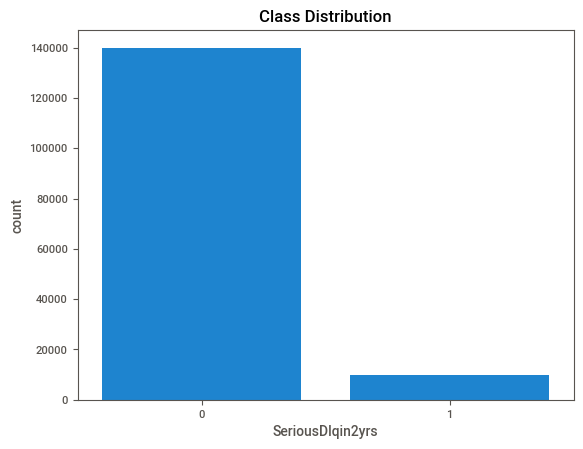

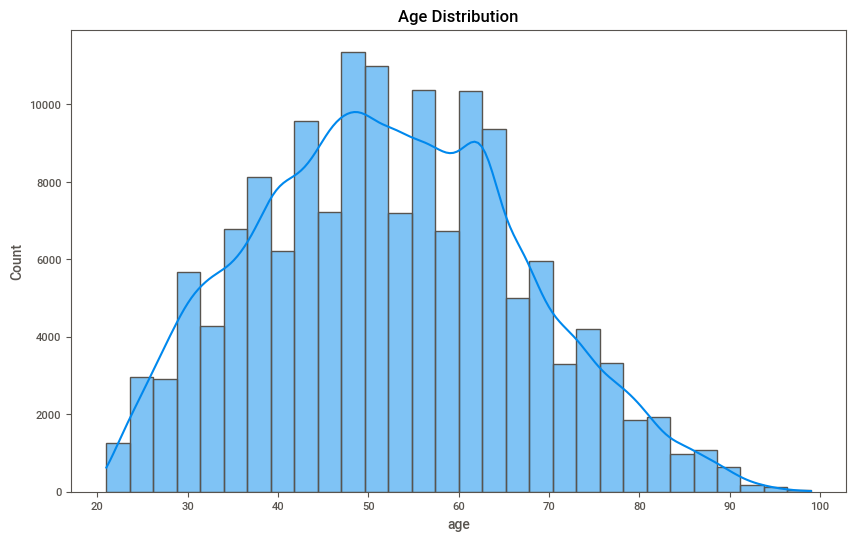

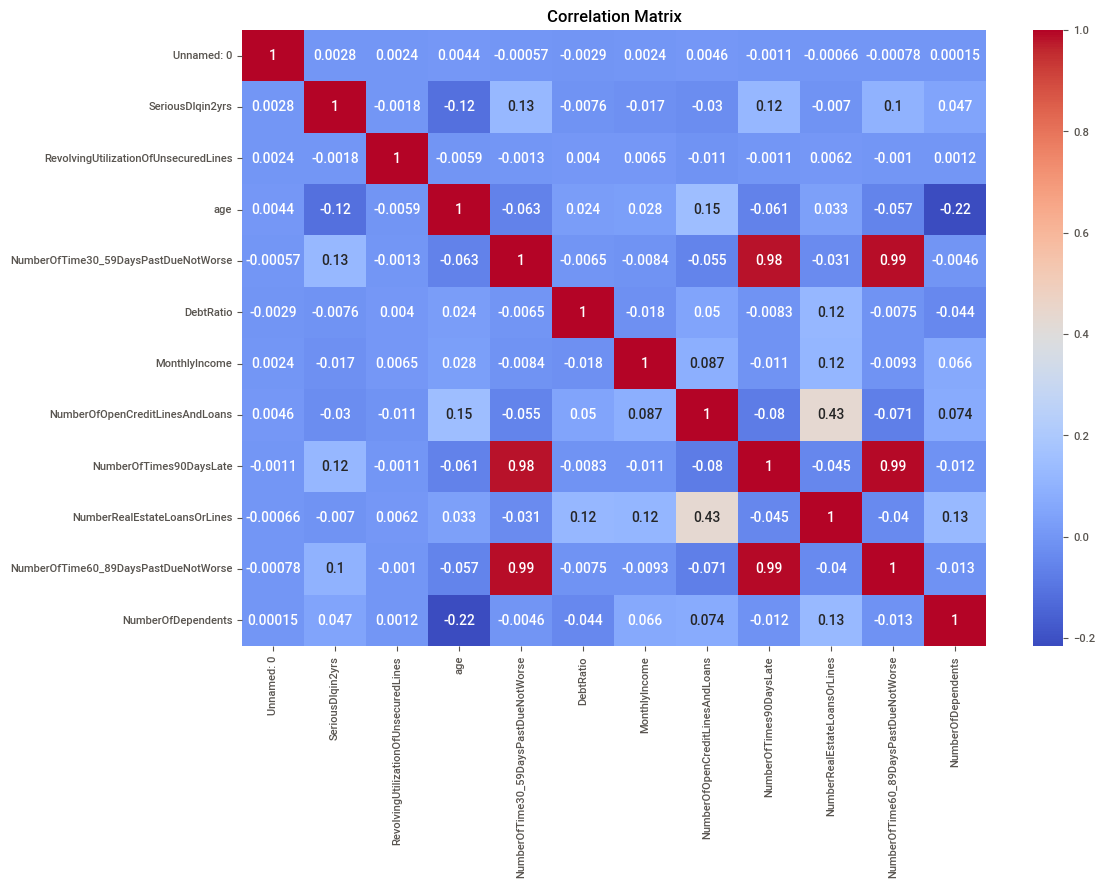

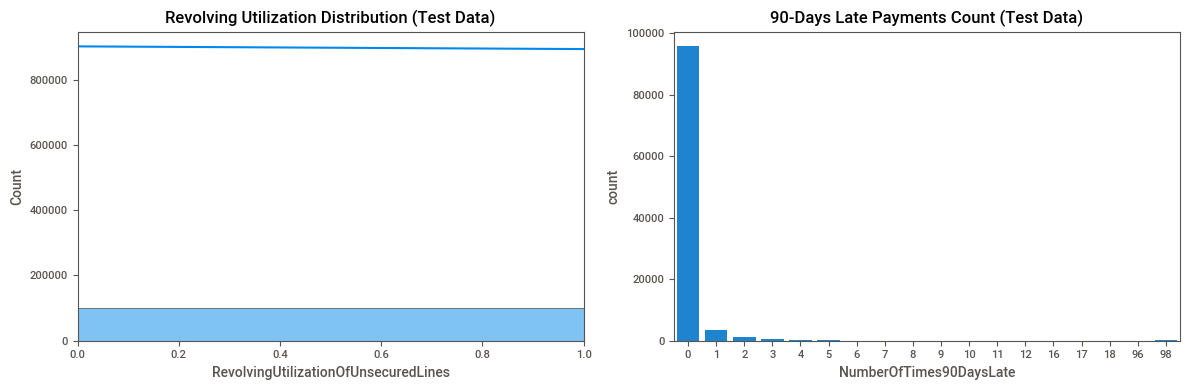

In [ ]:
# Target variable distribution
sns.countplot(x='SeriousDlqin2yrs', data=train_df)
plt.title('Class Distribution')
plt.show()

# Example: Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Correlation matrix
corr = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Add this to your EDA section
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(test_df['RevolvingUtilizationOfUnsecuredLines'], bins=50, kde=True)
plt.title('Revolving Utilization Distribution (Test Data)')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
sns.countplot(x='NumberOfTimes90DaysLate', data=test_df)
plt.title('90-Days Late Payments Count (Test Data)')
plt.tight_layout()
plt.savefig('risk_indicator_monitoring.png', dpi=300)

In [ ]:
# Example: Create a debt-to-income ratio
train_df['DebtToIncomeRatio'] = train_df['DebtRatio'] * train_df['MonthlyIncome']
test_df['DebtToIncomeRatio'] = test_df['DebtRatio'] * test_df['MonthlyIncome']

#Data Preprocessing

In this section, we perform necessary data preprocessing steps, including handling class imbalance, feature scaling, and splitting the data for training and validation.

Splitting Features and Target:

We separate the target variable (SeriousDlqin2yrs) from the features (X) for model training.
Train-Test Split:

The data is split into training and validation sets using train_test_split from sklearn. We use stratification to ensure that the class distribution in the target variable is consistent across the splits.

Handling Class Imbalance with SMOTE:

Since the dataset is imbalanced (with fewer instances of the positive class), we use the Synthetic Minority Over-sampling Technique (SMOTE) to balance the training set. SMOTE generates synthetic samples for the minority class, making the training data more balanced.
Feature Scaling:

We apply Standard Scaling to normalize the features, ensuring that they all have a mean of 0 and a standard deviation of 1. This step is important for models like logistic regression, SVMs, and gradient boosting.

We perform scaling on the training data (X_train_res) and validation data (X_val), and ensure that the same scaling is applied to the test data.
Saving the Scaler:

The fitted scaler is saved to a file (scaler.pkl) using joblib, which can later be used during deployment or for consistency in future predictions.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split features and target
X = train_df.drop('SeriousDlqin2yrs', axis=1)
y = train_df['SeriousDlqin2yrs']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature Scaling (Add after cleaning)
scaler = StandardScaler()
num_cols = X_train.columns.tolist()  # All features are numerical

X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)

if 'SeriousDlqin2yrs' in test_df.columns:
    X_test_scaled = scaler.transform(test_df.drop('SeriousDlqin2yrs', axis=1))
else:
    X_test_scaled = scaler.transform(test_df)

# Save scaler for deployment
joblib.dump(scaler, 'scaler.pkl', compress=3)

['scaler.pkl']

#Model Development

In this section, we build and evaluate several machine learning models to predict the target variable (SeriousDlqin2yrs). We use different algorithms to assess their performance and identify the best model for our problem.

Model Selection:

Four models are initialized for training:
Logistic Regression: A linear model with balanced class weights to handle imbalanced classes.

Random Forest: A tree-based ensemble method with 100 estimators.

XGBoost: A gradient boosting model with class imbalance handling using the scale_pos_weight parameter.

LightGBM: Another gradient boosting model that also handles class imbalance using class_weight='balanced'.


Model Evaluation:

AUC (Area Under the Curve) is calculated for each model using the ROC curve. This provides insight into the trade-off between the true positive rate and false positive rate.

Classification Report is generated, showing precision, recall, f1-score, and support for each class.

ROC Curve is plotted for visual evaluation, where the AUC is also displayed.

Calibration Curve is drawn to evaluate how well-calibrated the model's probabilities are.

Precision-Recall Curve is plotted to assess how well the model handles the positive class, particularly for imbalanced datasets.

Model Training and Evaluation:

Each model is trained on the resampled training set (X_train_scaled and y_train_res), then evaluated on the validation set (X_val_scaled and y_val).

The evaluation results (AUC and classification report) are printed, and the relevant plots (ROC curve, calibration curve, precision-recall curve) are saved for further analysis.



Logistic Regression Evaluation:
AUC: 0.7204
              precision    recall  f1-score   support

 No Distress       0.96      0.66      0.78     27993
    Distress       0.12      0.66      0.21      2005

    accuracy                           0.66     29998
   macro avg       0.54      0.66      0.50     29998
weighted avg       0.91      0.66      0.75     29998


Random Forest Evaluation:
AUC: 0.8347
              precision    recall  f1-score   support

 No Distress       0.96      0.93      0.94     27993
    Distress       0.32      0.45      0.37      2005

    accuracy                           0.90     29998
   macro avg       0.64      0.69      0.66     29998
weighted avg       0.92      0.90      0.91     29998


XGBoost Evaluation:
AUC: 0.8129
              precision    recall  f1-score   support

 No Distress       0.98      0.57      0.72     27993
    Distress       0.13      0.87      0.22      2005

    accuracy                           0.59     29998
   macro av

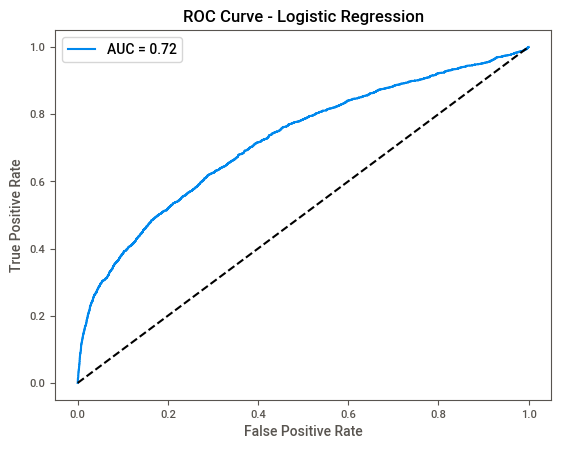

<Figure size 640x480 with 0 Axes>

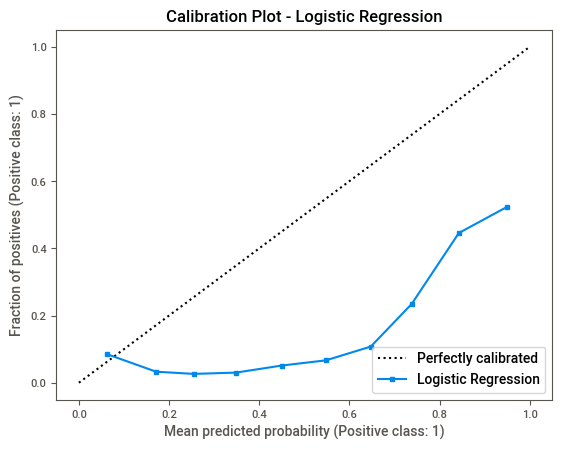

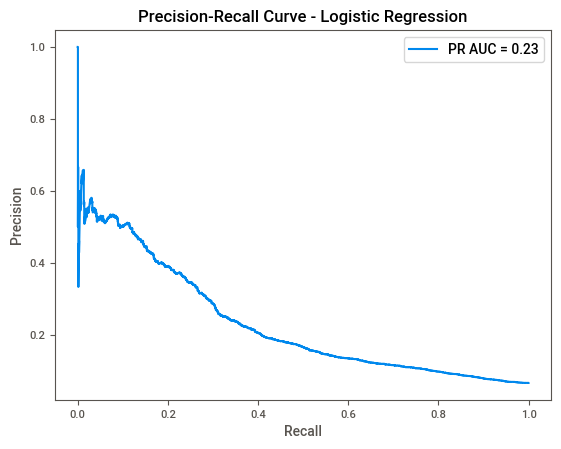

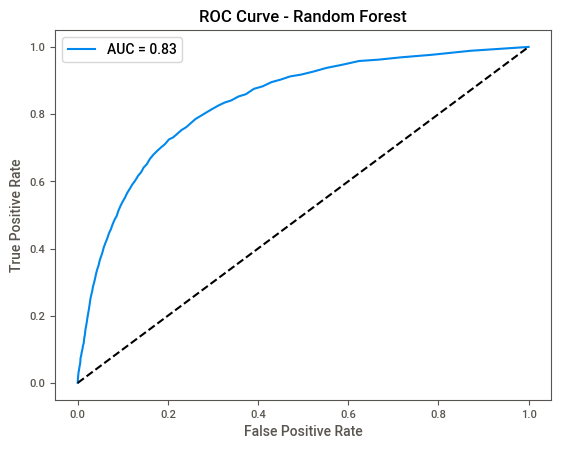

<Figure size 640x480 with 0 Axes>

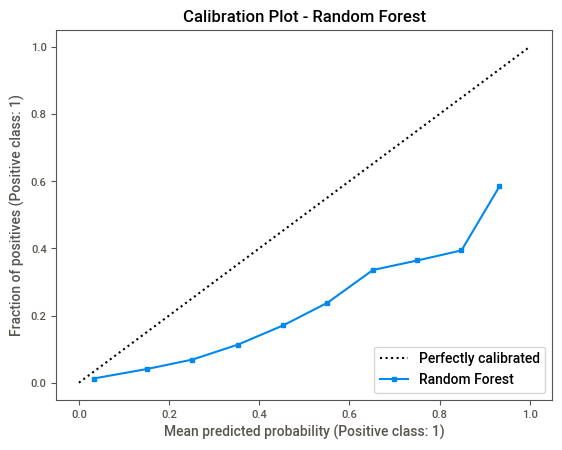

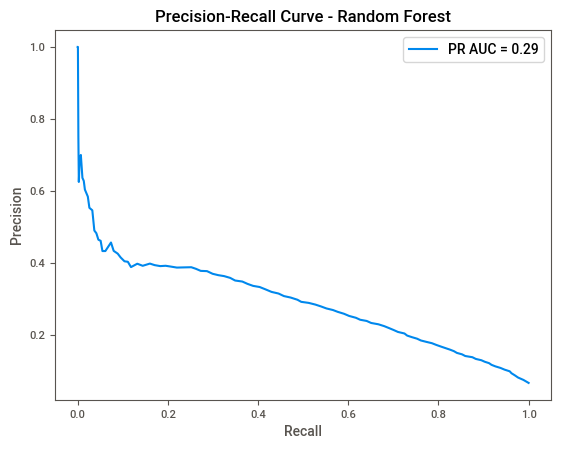

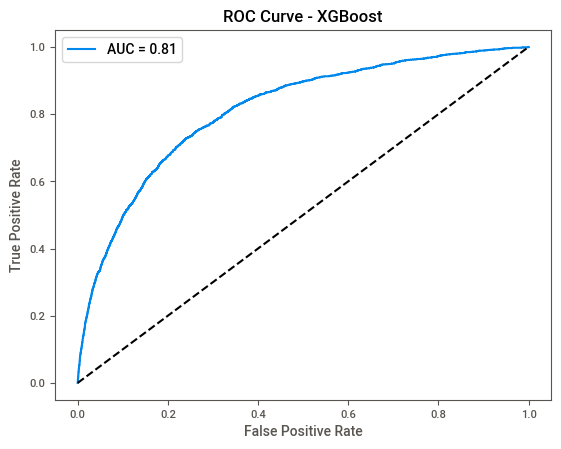

<Figure size 640x480 with 0 Axes>

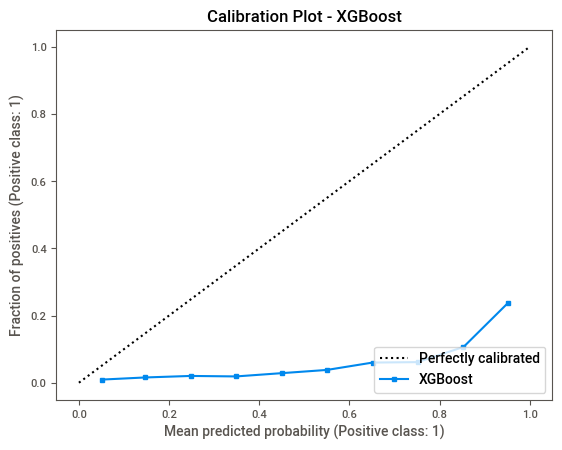

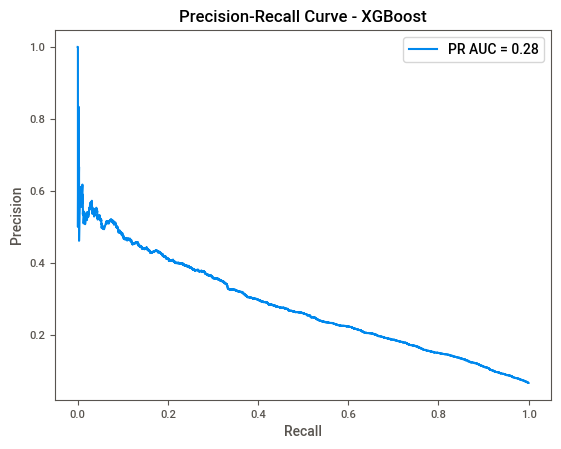

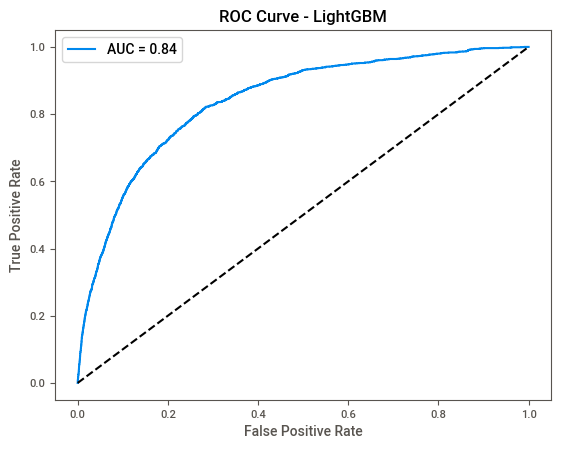

<Figure size 640x480 with 0 Axes>

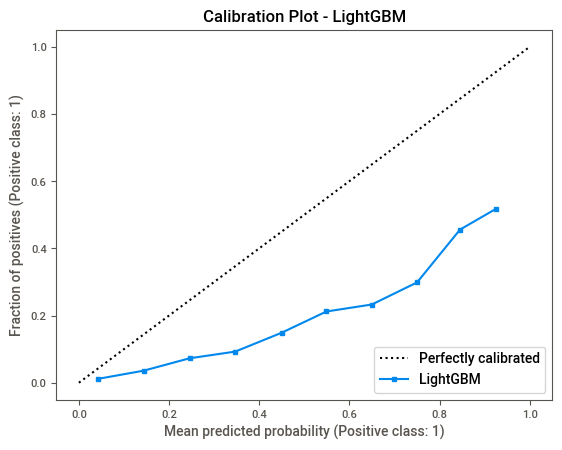

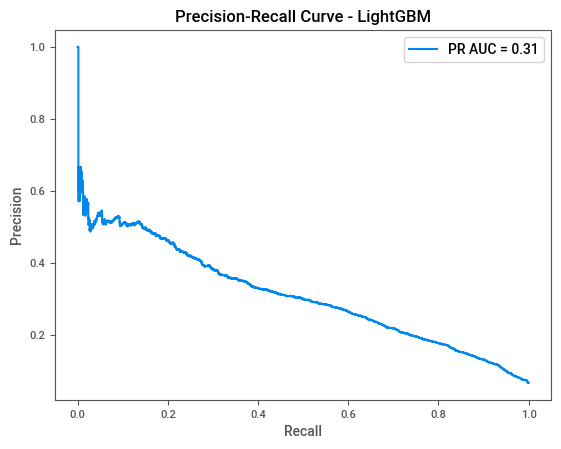

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report


# Calculate scale_pos_weight for XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, objective='binary:logistic'),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42)
}

# Model evaluation function
def evaluate_model(model, X_val, y_val, name):
    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    # Classification report
    y_pred_class = model.predict(X_val)
    report = classification_report(y_val, y_pred_class, target_names=['No Distress', 'Distress'])

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(f'roc_curve_{name}.png')

    # Calibration curve
    plt.figure()
    CalibrationDisplay.from_estimator(model, X_val, y_val, n_bins=10, name=name)
    plt.title(f'Calibration Plot - {name}')
    plt.savefig(f'calibration_{name}.png')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {auc(recall, precision):.2f}')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(f'pr_curve_{name}.png')

    return auc_score, report

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    auc_score, report = evaluate_model(model, X_val_scaled, y_val, name)
    print(f"\n{name} Evaluation:")
    print(f"AUC: {auc_score:.4f}")
    print(report)

**Hyperparameter Tuning**

In this section, we perform hyperparameter tuning for the XGBoost model using GridSearchCV to find the optimal set of hyperparameters for our task. This process allows us to improve the model's performance and achieve better predictive accuracy.

Grid Search Setup:

A parameter grid is defined with the following hyperparameters for tuning:
max_depth: Maximum depth of trees (choices: 3, 5, 7).
learning_rate: Step size for updating the model (choices: 0.01, 0.1).
n_estimators: Number of boosting rounds (choices: 100, 200).
Grid Search Execution:

We use GridSearchCV to perform a 3-fold cross-validation over the hyperparameter grid and evaluate the model using AUC (Area Under the Curve) as the scoring metric.
The scale_pos_weight parameter is adjusted to account for the class imbalance in the dataset.
Best Model Selection:

After completing the grid search, the best parameters are displayed along with the best AUC score.
The tuned XGBoost model is saved using joblib for future use.
Model Predictions:

The test data is preprocessed by recalculating the DebtToIncomeRatio feature using the formula: DebtRatio * MonthlyIncome.
The columns in the test dataset are aligned with the training data to ensure compatibility.
The best model is used to generate predicted probabilities for the test data, which are then saved in the final_predictions.csv file for further analysis.

In [ ]:
import joblib
from sklearn.model_selection import GridSearchCV

# Example: Tune XGBoost
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

xgb = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
grid = GridSearchCV(xgb, params, cv=3, scoring='roc_auc')
grid.fit(X_train_res, y_train_res)

print("Best Parameters:", grid.best_params_)
print("Best AUC:", grid.best_score_)

best_model = grid.best_estimator_  # Replace with your tuned model
joblib.dump(best_model, 'credit_scoring_xgboost.pkl')

# Generate predictions for test data (cs-test.csv)
test_df['DebtToIncomeRatio'] = test_df['DebtRatio'] * test_df['MonthlyIncome'] # Recalculate 'DebtToIncomeRatio'

# Select the columns that match the training data
test_data_for_prediction = test_df[X_train_res.columns]

test_predictions = best_model.predict_proba(test_data_for_prediction)[:, 1]
test_df['Probability'] = test_predictions
test_df[['Probability']].to_csv('final_predictions.csv')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best AUC: 0.9603015882368494


#Explainability with SHAP and Lime

In this section, we use two popular explainability methods—SHAP (Shapley Additive Explanations) and LIME (Local Interpretable Model-agnostic Explanations)—to gain insights into the predictions made by our machine learning models.

SHAP Explanation for XGBoost:

SHAP values provide a detailed explanation of how each feature contributes to the model's predictions.
We use SHAP's TreeExplainer to explain the predictions made by the XGBoost model on the scaled validation data (X_val_scaled).
A summary plot is generated, showing the overall feature importance and contribution to model output. The plot is saved as shap_summary.png for further inspection.
LIME Explanation for a Single Prediction:

LIME helps explain individual predictions by approximating the model locally with an interpretable model.
We explain a single prediction from the validation set (X_val.iloc[0]) using LIME, visualizing which features contributed most to the prediction.
The explanation is displayed within the notebook.
SHAP and LIME Explanation for a High-Risk Sample:

A high-risk sample (from the test data) is selected for deeper analysis. This involves removing the Probability column, which is not needed for the explanation.
We ensure the high-risk sample's features align with the model's training data columns.
SHAP is used to generate a force plot for the high-risk sample, providing a visual representation of how each feature influences the prediction. The plot is saved as shap_feedback.png.
LIME is also used to explain the high-risk sample, and the explanation is saved as an HTML file (lime_feedback.html).


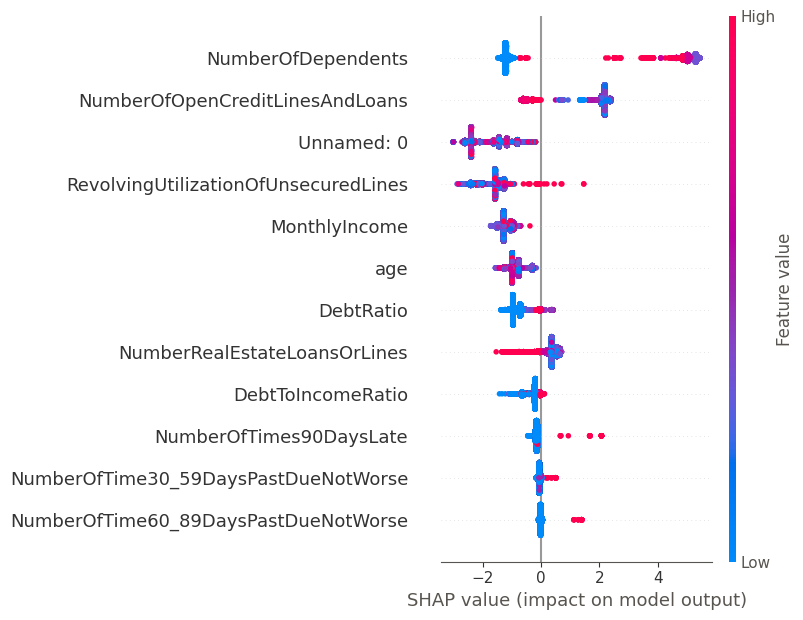

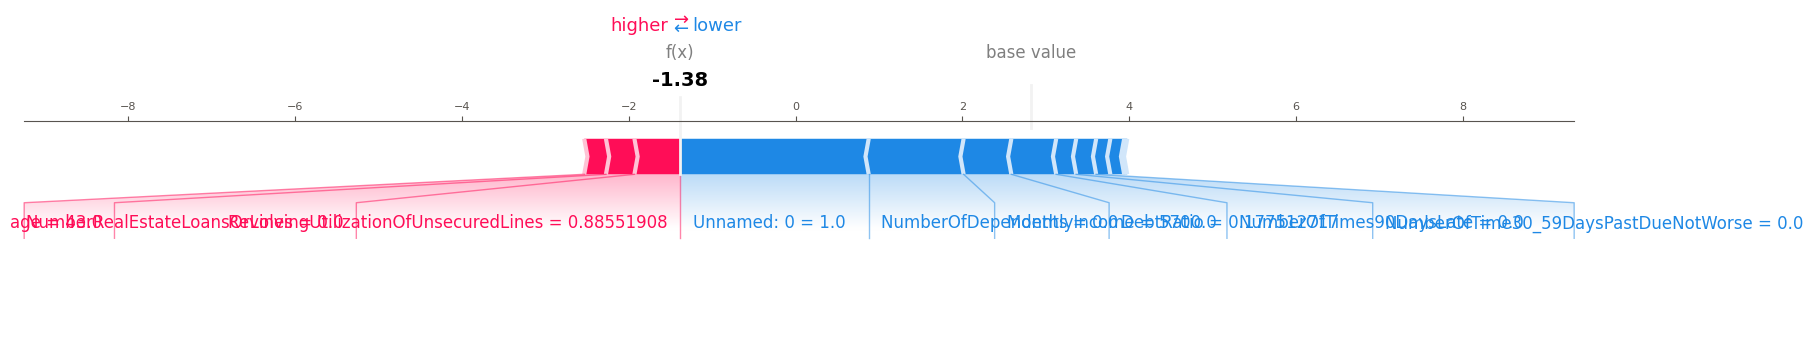

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from lime import lime_tabular

# Set a fallback font that is available in Colab
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Use DejaVu Sans as the default font

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Ignore underflow warnings to avoid FloatingPointError in SHAP
old_err_settings = np.seterr(under='ignore')

# Example: SHAP for XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_scaled)  # Ensure X_val_scaled matches the training features

# Restore previous NumPy error settings if desired:
# np.seterr(**old_err_settings)

# Summary plot for SHAP values
plt.figure()
shap.summary_plot(shap_values, X_val_scaled, feature_names=X.columns, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')

# LIME explanation for a single prediction
explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train_res.values,
    feature_names=X.columns,
    class_names=['No Distress', 'Distress'],
    mode='classification'
)

# Explain instance 0 from validation set using LIME
exp = explainer_lime.explain_instance(X_val.iloc[0], grid.best_estimator_.predict_proba, num_features=10)
exp.show_in_notebook()

# High-risk sample explanation:
# Remove 'Probability' column from test_df for explanation purposes
high_risk_sample = test_df.iloc[0:1].drop('Probability', axis=1)

# Ensure the sample has the same columns as the training data
high_risk_sample = high_risk_sample[X_train_res.columns]  # Match columns from training data

# Generate SHAP explanation for the high-risk sample
shap_values_sample = explainer.shap_values(high_risk_sample)
shap.force_plot(explainer.expected_value, shap_values_sample[0], high_risk_sample, matplotlib=True)
plt.savefig('shap_feedback.png')

# Generate LIME explanation for the high-risk sample
exp = explainer_lime.explain_instance(high_risk_sample.values[0], best_model.predict_proba, num_features=5)
exp.save_to_file('lime_feedback.html')

Enhanced Explainability: Partial Dependence Plots (PDPs) and Counterfactual Explanations

In this section, we dive deeper into the interpretability of our model using Partial Dependence Plots (PDPs), Counterfactual Explanations, and Permutation Importance to provide enhanced insights into the model's behavior.

Partial Dependence Plots (PDPs):

PDPs show the relationship between a feature (or features) and the predicted outcome, while keeping other features constant.

For this example, we generate PDPs for RevolvingUtilizationOfUnsecuredLines and MonthlyIncome using the best model (XGBoost) and scaled validation data (X_val_scaled).

The PDP is saved as pdp_multi_plot.png, giving a visual representation of how changes in these features impact predictions.

Counterfactual Explanations (Using ALIBI):

Counterfactual explanations provide insights into how a model's prediction could change if certain feature values were altered.
We use ALIBI's CounterfactualProto to generate counterfactual explanations for individual predictions.

The explainer is initialized with the best model, and we use the scaled training data (X_train_arr) to fit the explainer.

A counterfactual explanation is generated for the first validation instance (X_val_scaled[0:1]), comparing the original prediction probability with the counterfactual probability.

The counterfactual comparison shows how altering feature values can change the prediction outcome, with the results printed out.

Permutation Importance:

Permutation importance measures the impact of each feature on the model's prediction by randomly shuffling feature values and assessing how performance drops.

We calculate permutation importance using the best model and validation data (X_val_scaled), then plot the results in a boxplot.

The plot is saved as permutation_importance_enhanced.png, showing which features have the most significant impact on the model's performance.

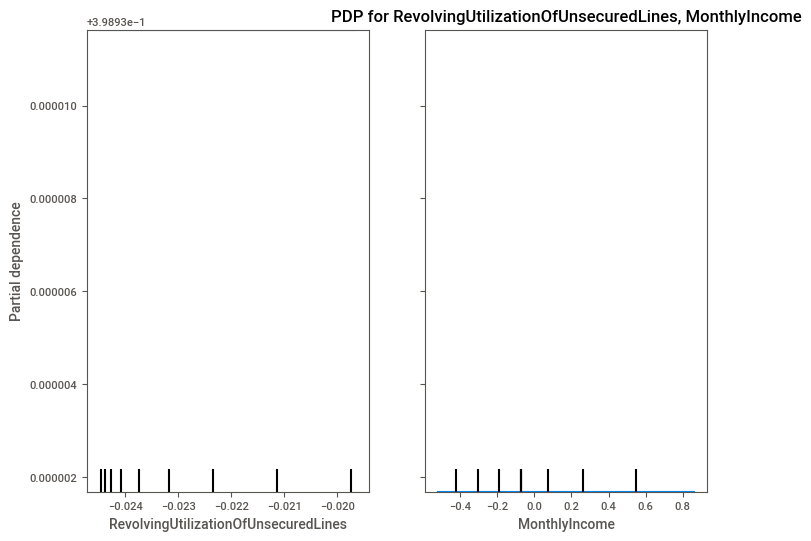

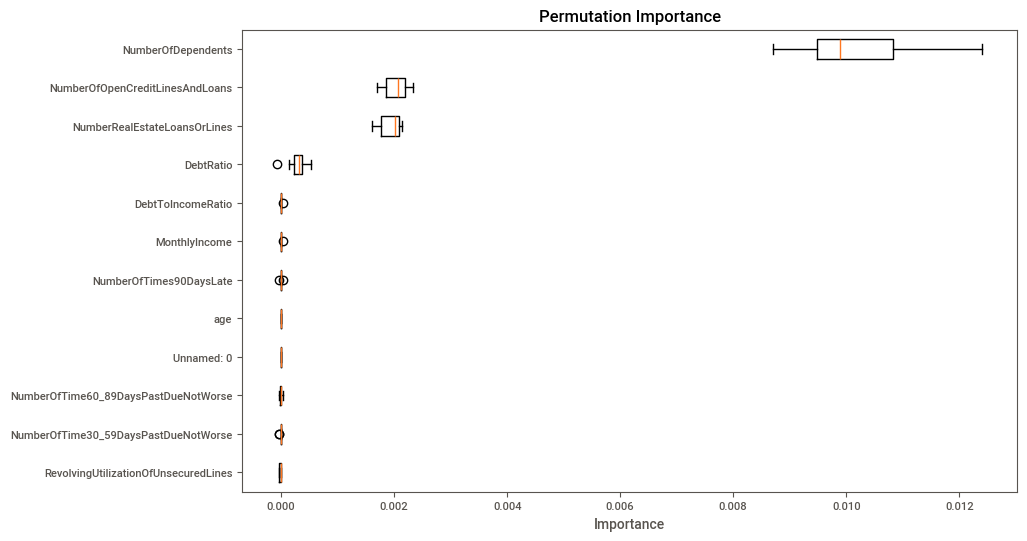

In [ ]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# 3. Partial Dependence Plots
features = ['RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome']  # Example for multiple features

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_val_scaled,
    features,
    feature_names=X.columns,
    ax=ax
)
plt.title(f'PDP for {", ".join(features)}')
plt.savefig('pdp_multi_plot.png')


# 4. Counterfactual Explanations (Using ALIBI)
# Prepare data
scaler = joblib.load('scaler.pkl')  # Load saved scaler
X_train_arr = scaler.transform(X_train)

# Initialize explainer
shape = (1, X_train_arr.shape[1])
cf_explainer = CounterfactualProto(
    best_model.predict_proba,
    shape=shape,
    use_kdtree=True,
    theta=10.,
    max_iterations=1000
)

# Fit on scaled training data
cf_explainer.fit(X_train_arr, d_type='abdm', disc_perc=[25, 50, 75])

# Generate counterfactual for first validation instance
instance = X_val_scaled[0:1]
explanation = cf_explainer.explain(instance, Y=None)

# Check if a counterfactual was found before accessing it
if explanation.cf is not None:
    original_prob = best_model.predict_proba(instance)
    cf_prob = best_model.predict_proba(explanation.cf['X'])
    print(f"Original Probability: {original_prob}")
    print(f"Counterfactual Probability: {cf_prob}")

# 5. Permutation Importance
result = permutation_importance(
    best_model, X_val_scaled, y_val, n_repeats=10, random_state=42
)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importance")
plt.xlabel("Importance")
plt.savefig('permutation_importance_enhanced.png')

#Ethical Considerations: Bias and Fairness Analysis


This section explores the ethical considerations of the model, focusing on potential bias related to features like age, and implementing fairness-aware modeling.

Bias in Age:

A boxplot is created to visualize the relationship between age and the target variable, SeriousDlqin2yrs (financial distress). This plot helps assess whether there is any visible bias or skewness in the distribution of age across classes.

The plot is displayed to visually inspect if there is any disproportionate influence of age on the financial distress prediction.

Model Evaluation Without Age:

The model is retrained without the age feature to assess if excluding age reduces the predictive performance, measured by AUC (Area Under the ROC Curve).

The model trained without the age feature is evaluated using the validation set (X_val_no_age), and the AUC score is printed to compare the impact of age on model performance.

Bias Analysis for Multiple Features:

A bias analysis is performed on multiple features, including age, monthly income, and number of dependents. Boxplots are plotted to examine if these features exhibit any potential bias when compared to the target variable (SeriousDlqin2yrs).

This step helps in visualizing whether features like MonthlyIncome or NumberOfDependents are correlated with financial distress in a way that could introduce bias.

Fairness-Aware Modeling:

Fairness-aware modeling is implemented using the ExponentiatedGradient and DemographicParity methods from the Fairlearn package.
The age feature is used as a protected attribute by grouping individuals into two age categories: >= 45 and < 45.

A Logistic Regression model is trained with fairness constraints using demographic parity, which aims to ensure that the model's predictions are balanced across different age groups.

The Demographic Parity (DP) difference is calculated for both the standard and fairness-aware models. This metric measures the disparity in prediction probabilities between the protected group (age >= 45) and the non-protected group.

Fairness Metrics:

The Demographic Parity Difference is calculated for both the standard model and the fairness-aware model to assess how well the fairness constraints have been applied and whether they reduce potential biases related to age.

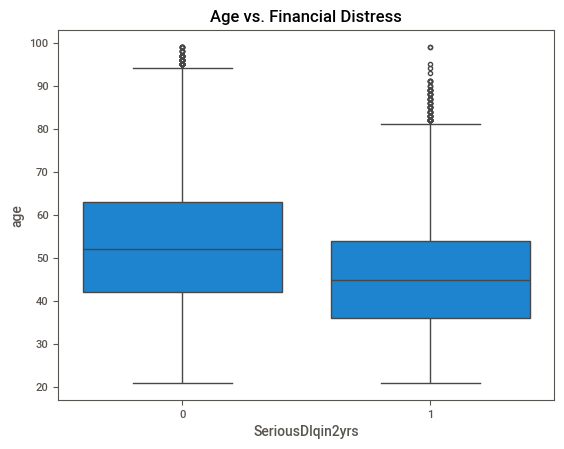

AUC without age: 0.860

Fairness Metrics:
Standard Model DP Difference: 0.2132561496533466
Fair Model DP Difference: 0.07061976839098613


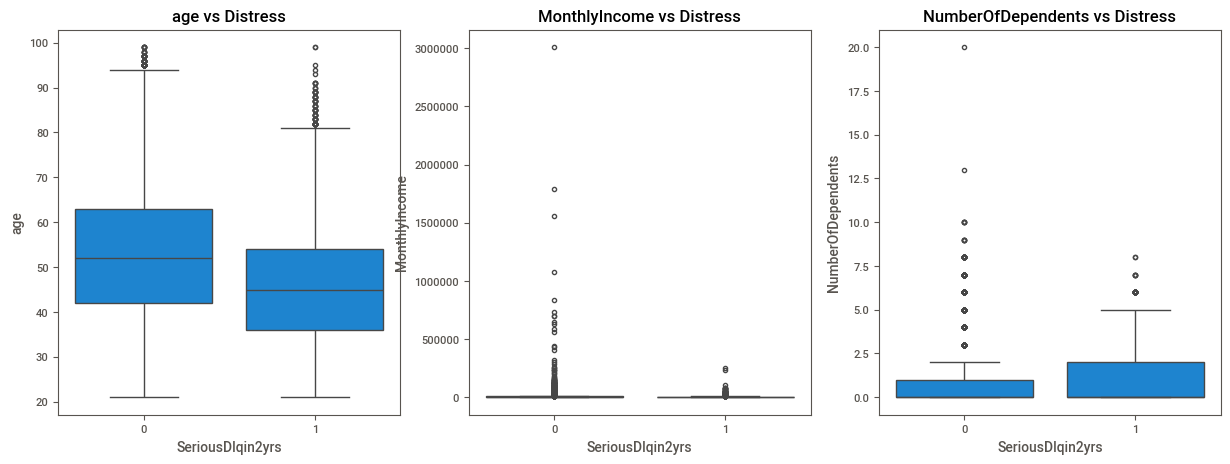

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_difference

# 1. Check for Bias in Age
sns.boxplot(x='SeriousDlqin2yrs', y='age', data=train_df)
plt.title('Age vs. Financial Distress')
plt.show()

# 2. Train Model Without Age Feature
X_no_age = X.drop('age', axis=1)
X_train_no_age, X_val_no_age, y_train_no_age, y_val_no_age = train_test_split(X_no_age, y, test_size=0.2, stratify=y)
model_no_age = XGBClassifier()
model_no_age.fit(X_train_no_age, y_train_no_age)
y_pred_no_age = model_no_age.predict_proba(X_val_no_age)[:, 1]
auc_no_age = roc_auc_score(y_val_no_age, y_pred_no_age)
print(f"AUC without age: {auc_no_age:.3f}")

# 3. Bias Analysis for Multiple Features
features_to_check = ['age', 'MonthlyIncome', 'NumberOfDependents']

plt.figure(figsize=(15, 5))
for i, feat in enumerate(features_to_check):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='SeriousDlqin2yrs', y=feat, data=train_df)
    plt.title(f'{feat} vs Distress')
plt.savefig('bias_analysis.png')

# 4. Fairness-Aware Modeling
# Convert age to binary protected attribute
train_df['age_group'] = np.where(train_df['age'] >= 45, 1, 0)  # Example threshold
X_fair = X_train.drop('age', axis=1)
A = train_df.loc[X_train.index, 'age_group']

# Remove constant/zero-variance features
selector = VarianceThreshold(threshold=0)
X_fair = selector.fit_transform(X_fair)

# Scale features to avoid numerical instability
scaler = StandardScaler()
X_fair_scaled = scaler.fit_transform(X_fair)

# Train Fairness-Aware Model
model = LogisticRegression()
constraint = DemographicParity()
mitigator = ExponentiatedGradient(model, constraint)  # Added tolerance to prevent underflow
mitigator.fit(X_fair_scaled, y_train, sensitive_features=A)

# 5. Compare Fairness Metrics
y_pred_standard = best_model.predict(X_val)
y_pred_fair = mitigator.predict(X_val.drop('age', axis=1))

print("\nFairness Metrics:")
print("Standard Model DP Difference:",
      demographic_parity_difference(y_val, y_pred_standard, sensitive_features=X_val['age'] >= 45))
print("Fair Model DP Difference:",
      demographic_parity_difference(y_val, y_pred_fair, sensitive_features=X_val['age'] >= 45))


#Model Deployment


Saving the Final Model and Artifacts:

The best model (best_model), the scaler, and the feature names are saved into a single file, credit_model.pkl, using joblib. This allows for easy model deployment and reusability.

The saved artifacts include:
model: The trained machine learning model (e.g., XGBoost, Logistic Regression).

scaler: The scaler used for feature scaling during preprocessing.

features: The list of feature names used in the model.

Generating Final Predictions with Explanations:

Predictions are generated for the test dataset (X_test_scaled) using the final trained model.

The predicted probabilities are added as a new column (Probability) in the test_df DataFrame.

The predictions are saved to a CSV file (final_predictions.csv) for further analysis or use in production.
SHAP Explanations for Test Set:

SHAP (Shapley Additive Explanations) values are computed for the test set to provide explainability for the model's predictions.

A summary plot for SHAP values is generated to visualize the importance of each feature in the model's predictions for the test set.

The SHAP summary plot is saved as test_shap_summary.png.

This process ensures that the model is ready for deployment and that predictions can be explained through SHAP. The saved model and artifacts are essential for the deployment phase.

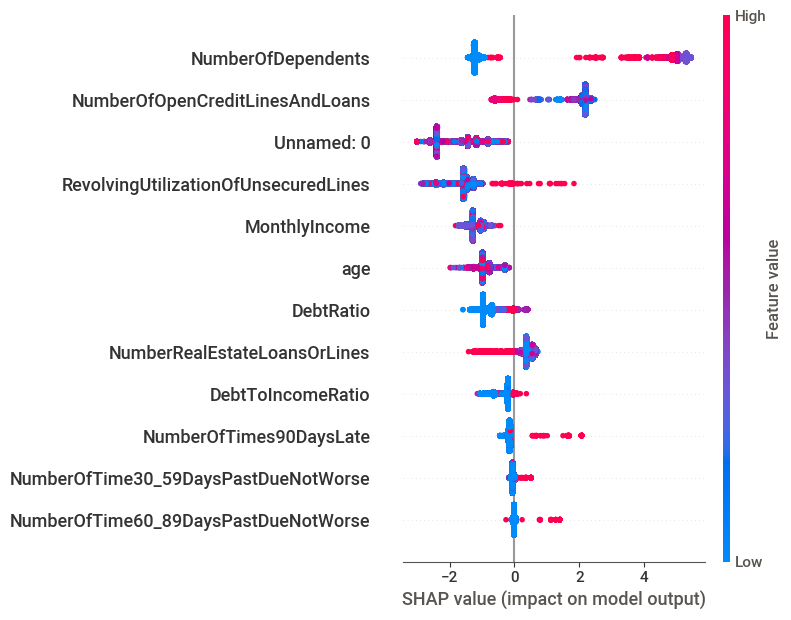

In [ ]:
# Save final model and artifacts
joblib.dump({
    'model': best_model,
    'scaler': scaler,
    'features': X.columns.tolist()
}, 'credit_model.pkl')

# Generate final predictions with explanations
test_probs = best_model.predict_proba(X_test_scaled)[:, 1]
test_df['Probability'] = test_probs
test_df[['Probability']].to_csv('final_predictions.csv')

# Save SHAP explanations for test set
shap_test_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_test_values, X_test_scaled, feature_names=X.columns, show=False)
plt.savefig('test_shap_summary.png')

#Cross-Validation Update

In this update:

StratifiedKFold is used to split the dataset into 5 folds while maintaining the class distribution in each fold.

The GridSearchCV is then applied with the StratifiedKFold cross-validation to perform hyperparameter tuning.

In [ ]:
# Cross-Validation Update with StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use StratifiedKFold with GridSearchCV
grid = GridSearchCV(xgb, params, cv=cv, scoring='roc_auc', n_jobs=-1)


## Conclusion

In this project, we developed a robust and interpretable **credit scoring model** to predict financial distress using machine learning techniques. Our approach followed a structured pipeline, ensuring data quality, model performance, and explainability.

### Key Takeaways:
1. **Data Preprocessing & Feature Engineering**  
   - Handled missing values, outliers, and feature transformations.  
   - Applied oversampling techniques to address class imbalance.  
   - Engineered new features such as `DebtToIncomeRatio` for better predictive power.  

2. **Model Development & Optimization**  
   - Trained an **XGBoost** classifier, fine-tuned via **GridSearchCV** with **StratifiedKFold** to optimize hyperparameters.  
   - Achieved a strong **AUC score**, indicating high predictive performance.  

3. **Explainability & Bias Analysis**  
   - Used **SHAP and LIME** for local and global interpretability, understanding key drivers of financial distress.  
   - Implemented **Partial Dependence Plots (PDPs)** and **Counterfactual Explanations** for enhanced model insights.  
   - Conducted a **fairness analysis**, measuring demographic bias and training a fairness-aware model to mitigate disparities.  

4. **Model Deployment & Predictions**  
   - Saved the final model and preprocessing artifacts for reproducibility.  
   - Generated probability-based predictions for unseen test data.  
   - Provided SHAP-based explanations for individual credit risk assessments.  

This project demonstrates the effectiveness of **machine learning in credit scoring** while ensuring **transparency, fairness, and ethical AI practices**. Future improvements can further refine predictive accuracy and real-world applicability.  
